In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import tqdm

# Read image
# files  = sorted(glob.glob("/ssd_scratch/cvit/anirudhkaushik/dataset/ISIC_2019/ISIC_2019_Training_Input/*.jpg"))
# print(len(files))
# for f in tqdm.tqdm(files):
#     img = cv2.imread(f, cv2.IMREAD_COLOR)
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#     # resize to 224x224
#     img = cv2.resize(img, (224, 224),cv2.INTER_AREA )
#     # save over original
#     cv2.imwrite(f, img)


25331


100%|██████████| 25331/25331 [00:47<00:00, 538.80it/s]


In [8]:
import torch
import torch.nn as nn
import torchvision
from torchvision.models import ResNet101_Weights, resnet101

# Load pretrained model
# model = resnet101(weights=ResNet101_Weights.IMAGENET1K_V2)
model = resnet101()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
import pandas as pd

df_train = pd.read_csv("/ssd_scratch/cvit/anirudhkaushik/dataset/ISIC_2019/ISIC_2019_Training_GroundTruth.csv")
print(df_train.head())

          image  MEL   NV  BCC   AK  BKL   DF  VASC  SCC  UNK
0  ISIC_0000000  0.0  1.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
1  ISIC_0000001  0.0  1.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
2  ISIC_0000002  1.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
3  ISIC_0000003  0.0  1.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
4  ISIC_0000004  1.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0


In [10]:
from sklearn.model_selection import train_test_split
import os
def load_isic_2019():
    root = "/ssd_scratch/cvit/anirudhkaushik/dataset/ISIC_2019"
    """
    Load ISIC_2019 dataset and convert it to IIRC format

    Args:
        root (string): The location of the dataset
        intask_valid_train_ratio (float): the percentage of the training set to be taken for the in-task validation set
            , a training-like validation set used for valdation during the task training (default: 0.1)
        posttask_valid_train_ratio (float): the percentage of the training set to be taken for the post-task validation
            set, a test-like validation set used for valdation after the task training (default: 0.1)

    Returns:
        Dict[str, DatasetStructType]: datasets, a dictionary with the keys corresponding to the four splits (train,
        intask_validation, posttask_validation, test), and the values being a list of the samples that belong to
        each split (with the images provided in Image.Image type) in the DatasetTypeStruct structure
    """
    raw_data_meta_df = pd.read_csv(root+'/ISIC_2019_Training_GroundTruth.csv')

    isic_data_map = {
        "MEL": "Melanoma",  
        "NV": "Melanocytic_nevus" ,
        "BCC": "Basal_cell_carcinoma",
        "AK": "Actinic_keratosis",
        "BKL": "Benign_keratosis",
        "DF": "Dermatofibroma",
        "VASC": "Vascular_lesion",
        "SCC": "Squamous_cell_carcinoma"
    }
    
    labels = list(raw_data_meta_df.columns[1:-1])
    class_to_idx = {isic_data_map[label]: idx for idx, label in enumerate(labels)}

    

    X = raw_data_meta_df.iloc[:]['image'] # only image names, not actual images
    y = raw_data_meta_df.iloc[:, 1:]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1, stratify=y)

    raw_data_train = []
    for ind  in range(len(X_train)):
        img_name = X_train.iloc[ind]
        labels = y_train.iloc[ind]
        label = labels[labels == 1].index[0]
        if label != "MEL" and label != "NV" : # only take MEL and NV
            continue
        image = cv2.imread(os.path.join(root, "ISIC_2019_Training_Input", img_name+".jpg"), cv2.IMREAD_COLOR)
        image = cv2.resize(image, (224, 224), cv2.INTER_AREA) # remove later
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
        label = class_to_idx[isic_data_map[label]] 
        raw_data_train.append((image, label))


    raw_data_test = []
    for ind  in range(len(X_test)):
        img_name = X_test.iloc[ind]
        labels = y_test.iloc[ind]
        label = labels[labels == 1].index[0]
        if label != "MEL" and label != "NV" : # only take MEL and NV
            continue
        image = cv2.imread(os.path.join(root, "ISIC_2019_Training_Input", img_name+".jpg"), cv2.IMREAD_COLOR)
        image = cv2.resize(image, (224, 224), cv2.INTER_AREA) # remove later, inter area is for making it smaller, for making it larger use inter linear
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
        label = class_to_idx[isic_data_map[label]]
        raw_data_test.append((image, label))

    return raw_data_train, raw_data_test

In [11]:
train, test = load_isic_2019()

In [12]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# dataloader
class ISICDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img, label = self.data[idx]
        if self.transform:
            img = self.transform(img)
        return img, label
    
# transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225] )
])

# datasets
train_dataset = ISICDataset(train, transform=transform)
test_dataset = ISICDataset(test, transform=transform)

# dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [13]:
model.fc = nn.Linear(2048, 2)
model = torch.nn.DataParallel(model)
model = model.to(device)

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

def test_model(model, test_loader):
    model.eval()
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data = data.to(device)
            target = target.to(device)

            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    print('\nTest set: Accuracy: {:.0f}%\n'.format(
            100. * correct / len(test_loader.dataset)))
    
    return correct / len(test_loader.dataset)

def train_model(model, train_loader, test_loader, optimizer, epochs):
    acc_list = []
    loss_list = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for i, (data, target) in enumerate(train_loader):
            data = data.to(device)
            target = target.to(device)

            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if i % 100 == 99:
                print('[%d, %5d] loss: %.3f' % (epoch+1, i+1, running_loss/100))
                running_loss = 0.0
        
        acc = test_model(model, test_loader)
        acc_list.append(acc)
        loss_list.append(running_loss)

    return acc_list, loss_list



In [14]:
acc_list, loss_list = train_model(model, train_dataloader, test_dataloader, optimizer, 14)

[1,   100] loss: 0.628
[1,   200] loss: 0.732
[1,   300] loss: 0.637
[1,   400] loss: 0.576

Test set: Accuracy: 73%

[2,   100] loss: 0.558
[2,   200] loss: 0.564
[2,   300] loss: 0.585
[2,   400] loss: 0.546

Test set: Accuracy: 73%

[3,   100] loss: 0.575
[3,   200] loss: 0.517
[3,   300] loss: 0.537
[3,   400] loss: 0.539

Test set: Accuracy: 77%

[4,   100] loss: 0.537
[4,   200] loss: 0.594
[4,   300] loss: 0.542
[4,   400] loss: 0.572

Test set: Accuracy: 74%

[5,   100] loss: 0.569
[5,   200] loss: 0.521
[5,   300] loss: 0.526
[5,   400] loss: 0.527

Test set: Accuracy: 77%

[6,   100] loss: 0.502
[6,   200] loss: 0.528
[6,   300] loss: 0.511
[6,   400] loss: 0.535

Test set: Accuracy: 77%

[7,   100] loss: 0.502
[7,   200] loss: 0.498
[7,   300] loss: 0.482
[7,   400] loss: 0.527

Test set: Accuracy: 78%

[8,   100] loss: 0.517
[8,   200] loss: 0.467
[8,   300] loss: 0.492
[8,   400] loss: 0.468

Test set: Accuracy: 75%

[9,   100] loss: 0.493
[9,   200] loss: 0.482
[9,   300]

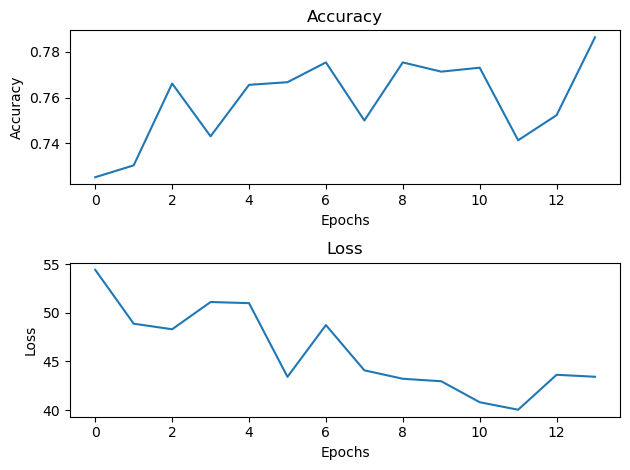

In [15]:
plt.subplot(2, 1, 1)
plt.plot(acc_list)
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.subplot(2, 1, 2)
plt.plot(loss_list)
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.tight_layout()
plt.show()

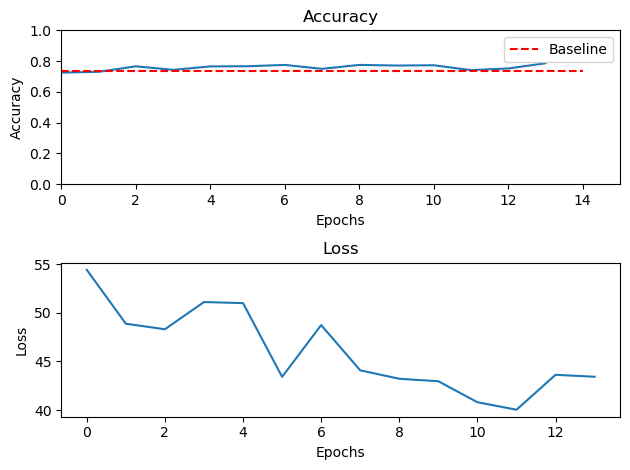

In [25]:
plt.subplot(2, 1, 1)
plt.plot(acc_list)
plt.title("Accuracy")
plt.hlines(0.738, 0, 14, colors='r', linestyles='dashed', label='Baseline')
plt.legend()
plt.xlim(0, 15)
plt.ylim(0, 1)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.subplot(2, 1, 2)
plt.plot(loss_list)
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.tight_layout()
plt.show()

In [16]:
final_test_acc = test_model(model, test_dataloader)
print("Final test accuracy: {:.0f}%".format(100. * final_test_acc))


Test set: Accuracy: 79%

Final test accuracy: 79%


In [22]:
def classwise_acc(model, test_loader):
    classes = ("Melanoma", "Melanocytic Nevus")
    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}

    # again no gradients needed
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            outputs = model(images)
            _, predictions = torch.max(outputs, 1)
            # collect the correct predictions for each class
            for label, prediction in zip(labels, predictions):
                if label == prediction:
                    correct_pred[classes[label]] += 1
                total_pred[classes[label]] += 1


    # print accuracy for each class
    for classname, correct_count in correct_pred.items():
        accuracy = 100 * float(correct_count) / total_pred[classname]
        print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

    return [correct_pred["Melanoma"] / total_pred["Melanoma"], correct_pred["Melanocytic Nevus"] / total_pred["Melanocytic Nevus"]]


In [23]:
classwise_score = classwise_acc(model, test_dataloader)
print("Melanoma class accuracy: {:.0f}%".format(100. * classwise_score[0]))
print("Melanocytic Nevus class accuracy: {:.0f}%".format(100. * classwise_score[1]))

Accuracy for class: Melanoma is 34.1 %
Accuracy for class: Melanocytic Nevus is 94.3 %
Melanoma class accuracy: 34%
Melanocytic Nevus class accuracy: 94%


In [21]:
torch.save(model.module.state_dict(), "./saved_models/melanocytic_exp1.pth")